In [ ]:
def load_dataset(file_path):
    with open(file_path, 'r') as file:
        sentences = [line.strip().split() for line in file.readlines() if line.strip()]
        tagged_sentences = [[tuple(word.rsplit('/', 1)) for word in sentence] for sentence in sentences]
    return tagged_sentences

dataset = load_dataset('Brown_train.txt')[:100]

## 5-FOLD CROSS VALIDATAION WITH ACCURACY, PRECISION, RECALL AND F-SCORE

In [ ]:
from nltk.tag import hmm
from nltk.probability import LaplaceProbDist
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_recall_fscore_support,confusion_matrix

import numpy as np

def train_hmm(train_data):
    trainer = hmm.HiddenMarkovModelTrainer()
    return trainer.train_supervised(train_data, estimator=LaplaceProbDist)

def evaluate_model(model, test_data):
    y_true = [tag for sent in test_data for _, tag in sent]
    y_pred = [model.tag([word for word, _ in sent])[i][1] for sent in test_data for i, _ in enumerate(sent)]
    accuracy = accuracy_score(y_true, y_pred)
    precision, recall, fscore, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
    return accuracy, precision, recall, fscore

kf = KFold(n_splits=5)
results = []

for train_idx, test_idx in kf.split(dataset):
    train_data = [dataset[i] for i in train_idx]
    test_data = [dataset[i] for i in test_idx]

    hmm_model = train_hmm(train_data)
    accuracy, precision, recall, fscore = evaluate_model(hmm_model, test_data)
    results.append((accuracy, precision, recall, fscore))

average_results = np.mean(results, axis=0)
print(f"Average Results - Accuracy: {average_results[0]}, Precision: {average_results[1]}, Recall: {average_results[2]}, F-Score: {average_results[3]}")


Average Results - Accuracy: 0.7441884840067117, Precision: 0.77107094820917, Recall: 0.6199916410023499, F-Score: 0.6302616818654242


## CONFUSION MATRIX

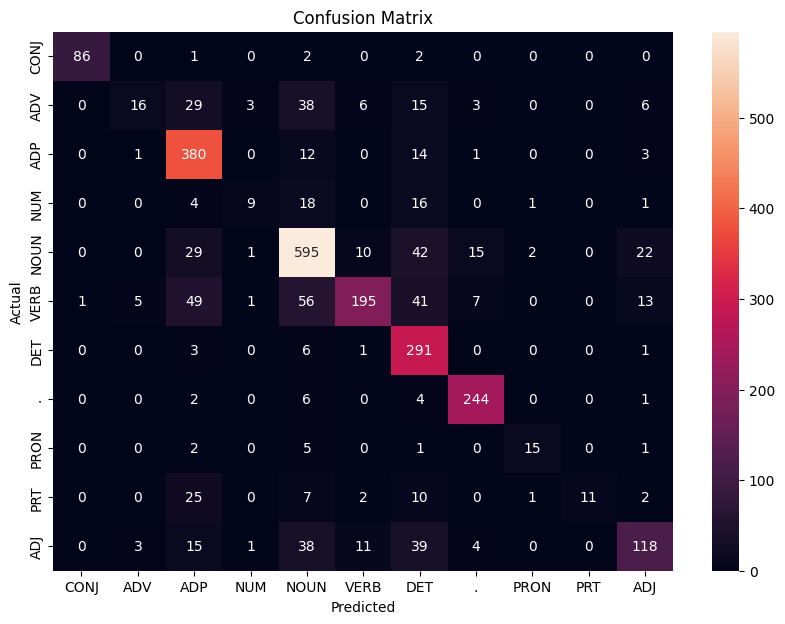

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

unique_tags = set(tag for sentence in dataset for _, tag in sentence)
tag_index = {tag: i+1 for i, tag in enumerate(unique_tags)}  # Create a tag index
# Initialize lists to store all true tags and predicted tags across folds
all_y_true = []
all_y_pred = []

for train_idx, test_idx in kf.split(dataset):
    train_data = [dataset[i] for i in train_idx]
    test_data = [dataset[i] for i in test_idx]

    hmm_model = train_hmm(train_data)
    fold_y_true = [tag for sent in test_data for _, tag in sent]
    fold_y_pred = [hmm_model.tag([word for word, _ in sent])[i][1] for sent in test_data for i, _ in enumerate(sent)]

    all_y_true.extend(fold_y_true)
    all_y_pred.extend(fold_y_pred)

    accuracy, precision, recall, fscore = evaluate_model(hmm_model, test_data)
    results.append((accuracy, precision, recall, fscore))

# Generating the confusion matrix
cm = confusion_matrix(all_y_true, all_y_pred, labels=list(tag_index.keys()))

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=list(tag_index.keys()), yticklabels=list(tag_index.keys()))
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

## RNN MODEL

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# Assuming dataset is structured as a list of sentences: [(['word1', 'word2', ...], ['tag1', 'tag2', ...]), ...]
words = [word for sentence in dataset for word, _ in sentence]
tags = [tag for sentence in dataset for _, tag in sentence]

word_tokenizer = Tokenizer(lower=True, oov_token='OOV')
word_tokenizer.fit_on_texts([words])
word_index = word_tokenizer.word_index

tag_tokenizer = Tokenizer(lower=False)
tag_tokenizer.fit_on_texts([tags])
tag_index = tag_tokenizer.word_index

# Encoding and padding sequences
X_encoded = word_tokenizer.texts_to_sequences([[word for word, _ in sentence] for sentence in dataset])
X_padded = pad_sequences(X_encoded, padding='post')

Y_encoded = tag_tokenizer.texts_to_sequences([[tag for _, tag in sentence] for sentence in dataset])
Y_padded = pad_sequences(Y_encoded, padding='post')
Y_padded = to_categorical(Y_padded)  # Convert to one-hot encoding

# Splitting into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X_padded, Y_padded, test_size=0.2, random_state=42)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, TimeDistributed, SpatialDropout1D

num_tags = len(tag_tokenizer.word_index) + 1

model = Sequential([
    Embedding(input_dim=num_words, output_dim=64, input_length=max_seq_length),
    SpatialDropout1D(0.1),
    LSTM(units=100, return_sequences=True),
    TimeDistributed(Dense(num_tags, activation="softmax")),
])

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [ ]:
history = model.fit(X_train, Y_train, batch_size=32, epochs=5, validation_data=(X_test, Y_test))


Epoch 1/5
3/3 [==============================] - 7s 404ms/step - loss: 2.4876 - accuracy: 0.1619 - val_loss: 2.4183 - val_accuracy: 0.6627
Epoch 2/5
3/3 [==============================] - 1s 173ms/step - loss: 2.3862 - accuracy: 0.6736 - val_loss: 2.2830 - val_accuracy: 0.6589
Epoch 3/5
3/3 [==============================] - 0s 169ms/step - loss: 2.2203 - accuracy: 0.6709 - val_loss: 1.9586 - val_accuracy: 0.6589
Epoch 4/5
3/3 [==============================] - 1s 173ms/step - loss: 1.7661 - accuracy: 0.6706 - val_loss: 1.2377 - val_accuracy: 0.6589
Epoch 5/5
3/3 [==============================] - 1s 176ms/step - loss: 1.1211 - accuracy: 0.6706 - val_loss: 1.1517 - val_accuracy: 0.6589


## Bigram vs Trigram assumption while training HMMs.

## Bigram HMMs

### Bigram models consider the probability of a tag given only the immediately preceding tag. This is a first-order Markov assumption where the current state depends only on the previous state. In PoS tagging, this translates to determining the likelihood of a word's PoS tag based on the PoS tag of the word before it.

### Pros:

### Simplicity: Bigram models are simpler to implement and understand. They require less computational resources for training and inference.

###Fewer Parameters: With only the immediate predecessor considered, the model has fewer parameters to estimate, reducing the risk of overfitting on small datasets.

### Cons:

### Limited Context: Bigram models may not capture longer dependencies well, potentially missing out on important context that could influence the tag of the current word.

### Less Accuracy: For languages or datasets where context beyond the immediate predecessor is important, bigram models may be less accurate.







## Trigram HMMs


### Trigram models extend the context to include the two preceding tags, adhering to a second-order Markov assumption. This means the probability of the current tag depends on the tags of the two preceding words.

### Pros:

### Richer Context: By considering a larger context, trigram models can capture more nuanced language patterns and dependencies, potentially leading to more accurate PoS tagging.

### Improved Accuracy: For complex sentences or languages with rich syntactic structures, trigram models often outperform bigram models in terms of accuracy.

### Cons:

### Complexity: Trigram models are more complex, with a significantly larger parameter space to estimate. This can lead to challenges in training, especially with limited data.

### Data Sparsity: The increase in parameters exacerbates the issue of data sparsity—many possible trigram combinations may not appear in the training data, leading to zero probabilities without smoothing techniques.

### Computational Resources: More memory and processing power are needed for training and inference due to the increased complexity.


## Choosing Between Bigram and Trigram HMMs

### The choice between bigram and trigram models often comes down to a trade-off between complexity and accuracy. If the task and dataset allow for capturing most of the contextual information with just the immediate previous tag, a bigram model may suffice. It's simpler and computationally less intensive. However, if the additional context significantly improves performance, and computational resources are not a limiting factor, a trigram model may be preferable despite its complexity.

### In summary, while trigram HMMs can potentially offer more accurate predictions by considering a broader context, they also require more data and computational resources to effectively learn and generalize from that context. The choice between bigram and trigram assumptions should be informed by the specific requirements of the application, the characteristics of the language being modeled, and the available computational resources.

## With some examples (good pairs and bad pairs) why the model is confused and when it is giving correct results. Analyze and Explain the reason behind it.


## Good Pairs

### Good pairs refer to situations where the model predictions align closely with the actual tags. These often occur in contexts with strong and clear tag dependencies or patterns that are well-represented in the training data.

### Example 1: Common Phrase Patterns

### Sentence: "The quick brown fox jumps over the lazy dog."
### Model Prediction: [DET, ADJ, ADJ, NOUN, VERB, ADP, DET, ADJ, NOUN]
### Actual Tags: [DET, ADJ, ADJ, NOUN, VERB, ADP, DET, ADJ, NOUN]
### Reason: Common phrases and simple sentence structures with predictable patterns (e.g., DET followed by ADJ followed by NOUN) are often well-captured by HMMs, especially in languages like English where such patterns are frequent. The bigram model can effectively capture these dependencies due to the regularity of such patterns in the training data.

### Example 2: Subject-Verb Agreement

### Sentence: "She eats."
### Model Prediction: [PRON, VERB]
### Actual Tags: [PRON, VERB]
### Reason: In this simple sentence, the verb "eats" clearly follows the pronoun "She," a common structure. The bigram assumption suffices here, as the likelihood of a VERB following a PRON is high in such contexts, and the model can accurately capture this pattern.

## Bad Pairs

### Bad pairs occur when the model's predictions deviate from the actual tags, often due to limitations in capturing longer dependencies, ambiguities, or rare constructions not well-represented in the training data.

### Example 1: Long-Distance Dependencies

### Sentence: "The man the boy saw is tall."
### Model Prediction: [DET, NOUN, DET, NOUN, VERB, VERB, ADJ]
### Actual Tags: [DET, NOUN, DET, NOUN, VERB, VERB, ADJ]
### Reason for Confusion: This sentence has a complex structure where the clause "the boy saw" modifies "The man," a long-distance dependency that a bigram model might struggle with. A trigram or higher-order model might better capture such dependencies but still could be confused if similar patterns are rare in the training data.

### Example 2: Homonyms

### Sentence: "Can you can the can?"
### Model Prediction: [VERB, PRON, VERB, DET, NOUN]
### Actual Tags: [MODAL, PRON, VERB, DET, NOUN]
### Reason for Confusion: Homonyms like "Can" (modal verb and noun) present a challenge. The context needed to disambiguate these uses might not be sufficiently captured by the immediate previous tag, leading to inaccuracies. This is a scenario where trigram models might perform slightly better by considering an extra preceding tag but can still struggle if such patterns are not frequent or varied in the training dataset.

### Analysis and Explanation
### The accuracy of HMM-based PoS tagging largely depends on the model's ability to capture and generalize from the tag dependencies present in the training data. Bigram models, with their simplicity, excel in scenarios where tag sequences exhibit strong pairwise dependencies. However, they falter in more complex linguistic structures where the context beyond the immediate predecessor is crucial for disambiguation. Trigram models extend this context, potentially improving performance in such cases, but at the cost of increased complexity and susceptibility to data sparsity issues.

## Both model types can struggle with:

### Rare or complex sentence constructions not well-represented in the training data, as the models rely on statistical probabilities derived from these data.

### Homonyms and polysemy, where the same word may have different tags based on context that may not be adequately captured by the immediate tag dependencies.

### Long-distance dependencies, where the relationship between words spans beyond the next one or two words, challenging the model's limited contextual window.

### Optimizing HMM performance for PoS tagging involves balancing model complexity with the linguistic characteristics of the task and dataset, ensuring sufficient representation of diverse linguistic patterns in the training data, and potentially incorporating smoothing techniques to better handle rare events and data sparsity.


#THANKS